*Dynamic Range Quantization*: 

In [1]:
#loading the model

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K

# Define the custom LSTM layer
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Define a custom MSE function
def custom_mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# Register custom objects
get_custom_objects().update({
    'CustomLSTM': CustomLSTM,
    'custom_mse': custom_mse
})

# Attempt to load the model
trained_model = load_model(r"C:\Users\pranali\Downloads\original_low_model.h5", 
                   custom_objects={'LSTM': CustomLSTM, 'mse': custom_mse})

# Print model summary
trained_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (CustomLSTM)               │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (CustomLSTM)             │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,911 (859.03 KB)

 Trainable params: 219,909 (859.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
import numpy as np

X_train = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\Mature(1)\Mature-main\Datasets\Training\all_data_low_train_x.npy")  # Shape should be (num_samples, time_steps, num_features)
y_train = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\Mature(1)\Mature-main\Datasets\Training\all_data_low_train_y.npy")  # Shape should be (num_samples, num_classes)
X_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\Mature(1)\Mature-main\Datasets\Testing\all_data_low_test_x.npy")
y_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\Mature(1)\Mature-main\Datasets\Testing\all_data_low_test_y.npy")

In [5]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K

#quantized model default

# Convert the model to a TensorFlow Lite model with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable Select TF ops to support operations not natively supported by TFLite
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]

# Disable lowering of tensor list operations, which might be causing the error
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable support
converter.experimental_enable_resource_variables = True

# Convert the model
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmp0cz2gyxs\assets


INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmp0cz2gyxs\assets


Saved artifact at 'C:\Users\pranali\AppData\Local\Temp\tmp0cz2gyxs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 11), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1840309793232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311027472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840309795920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840309796112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311028816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311028432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311029968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311031312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311029776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1840311032464: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [6]:
# Save the TFLite model
with open('model_quantized_low_5g_dynamic.tflite', 'wb') as f:
    f.write(tflite_quant_model)

In [7]:
# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='model_quantized_low_5g_dynamic.tflite')
interpreter.allocate_tensors()

# Get details of input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [13]:
# Initialize list to store predictions
import time

predictions = []

# Iterate over each sample in X_test
start_time = time.time()
for i in range(X_test.shape[0]):
    # Prepare the input data
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)
   
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
end_time = time.time()
inference_time = (end_time - start_time)
print(f"Inference Time for quantized low 5g sample: {inference_time:.6f} seconds")

avg_inference_time = (end_time - start_time)/len(X_test)
print(f"Avg Inference Time for quantized low 5g sample: {avg_inference_time:.6f} seconds")



Inference Time for quantized low 5g sample: 0.609926 seconds
Avg Inference Time for quantized low 5g sample: 0.001635 seconds


In [19]:
#original model
import time
# Predict on test data to compute R^2
start_time = time.time()
for i in range(0,len(X_test)):
   
    y_pred = trained_model.predict(X_test[i].reshape(1,10,11))
    print(i)
end_time = time.time()

# Inference time per sample
inference_time_4g = (end_time - start_time)
print(f"Inference Time for low 5g sample: {inference_time_4g:.6f} seconds")

avg_inference_time_4g = (end_time - start_time)/len(X_test)
print(f"Avg Inference Time for low 5g sample: {avg_inference_time_4g:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
#comparing model size

import os

def get_model_size(model):
    try:
        model_size = sum([np.prod(var.shape) for var in model.trainable_variables]) * 4
        return model_size / (1024 * 1024)  # MB
    except Exception as e:
        print(f"Error calculating model size: {e}")
        return None

# Model size in MB
model_size_params = trained_model.count_params()
model_size_bytes = model_size_params * 4  # 4 bytes per float32 parameter
model_size_mb = model_size_bytes / (1024 ** 2)  # Convert bytes to megabytes
print(f"Original Model Size: {model_size_mb:.2f} MB")
model_size_kb = model_size_bytes / 1024  # Convert bytes to kilobytes
print(f"Original Model Size: {model_size_kb:.2f} KB")


Original Model Size: 0.84 MB
Original Model Size: 859.02 KB


In [23]:
# Save the quantized TFLite model
with open('model_quantized_low_4g_dynamic.tflite', 'wb') as f:
    f.write(tflite_quant_model)

# Get the size of the saved quantized TFLite model
model_size = os.path.getsize('model_quantized_low_4g_dynamic.tflite')
print(f"Quantized TFLite model size: {model_size / 1024:.2f} KB")  # Convert to KB



Quantized TFLite model size: 258.16 KB


Mean Signed Error: 63.5370
Median Signed Error: 111.9184
Standard Deviation of Errors: 392.5905


Text(0, 0.5, 'Signed Error')

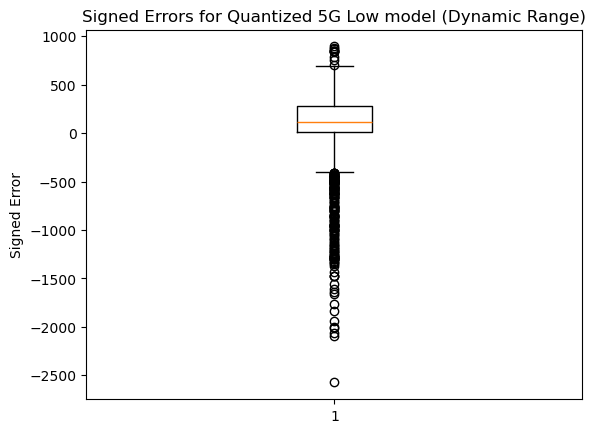

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run inference on the quantized model
predictions = []
for i in range(X_test.shape[0]):
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)  # Adjust dtype if needed
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

predictions = np.squeeze(np.array(predictions))  # Adjust shape if necessary

# Reshape y_test to match the shape of predictions
y_test_squeezed = np.squeeze(y_test)  # From (3995, 5, 1) to (3995, 5)

# Flatten signed_errors to combine all errors into a single array
signed_errors_flattened = signed_errors.flatten()

# Calculate signed errors
signed_errors = predictions - y_test_squeezed

# Error statistics
mean_error = np.mean(signed_errors)
median_error = np.median(signed_errors)
std_error = np.std(signed_errors)

print(f"Mean Signed Error: {mean_error:.4f}")
print(f"Median Signed Error: {median_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")

# Plot the violin plot with boxplot overlay
import matplotlib.pyplot as plt
plt.boxplot(signed_errors_flattened)
plt.title('Signed Errors for Quantized 5G Low model (Dynamic Range)')
plt.ylabel('Signed Error')

In [29]:
#quantized model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Calculate MAE
mae = mean_absolute_error(y_test_squeezed, predictions)
# Calculate Mean Squared Error (MSE) as the test loss
mse = mean_squared_error(y_test_squeezed, predictions)
test_loss = mse  # Assuming MSE is the loss function

print(f"Mean Squared Error (MSE) of the Quantized Model: {mse:.6f}")
print(f"Test Loss (MSE) of the Quantized Model: {test_loss:.6f}")
print(f"Mean Absolute Error (MAE) of the Quantized Model: {mae:.6f}")

Mean Squared Error (MSE) of the Quantized Model: 158164.214643
Test Loss (MSE) of the Quantized Model: 158164.214643
Mean Absolute Error (MAE) of the Quantized Model: 276.519365


In [31]:
#5g original low model

from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError

trained_model.compile(
    optimizer='adam',
    loss='mse',  # Or use the loss function that suits your problem
    metrics=[MeanAbsoluteError(), MeanSquaredError()]  # Proper metric objects
)

# Evaluate the model
results = trained_model.evaluate(X_test, y_test, verbose=1)

# Print the evaluation results
print(f"Test loss: {results[0]}")
print(f"Test MAE: {results[1]}")
print(f"Test MSE: {results[2]}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 193645.5781 - mean_absolute_error: 315.5160 - mean_squared_error: 193645.5781
Test loss: 158611.875
Test MAE: 276.9471435546875
Test MSE: 158611.859375


In [33]:
#error statistics for 5g low original

import time

# Predict on test data to compute R^2
start_time = time.time()
y_pred = trained_model.predict(X_test)
end_time = time.time()

# Inference time per sample
inference_time = (end_time - start_time) / len(X_test)
print(f"Inference Time per sample: {inference_time:.6f} seconds")

# Reshape y_test and y_pred to 2D arrays for r2_score calculation
y_test_reshaped = y_test.reshape(y_test.shape[0], -1)
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], -1)

# Compute Signed Errors
signed_errors = y_pred_reshaped - y_test_reshaped

# Flatten the signed errors into a 1D array
flattened_errors = signed_errors.flatten()

# Compute statistics of signed errors
mean_error = np.mean(flattened_errors)
std_dev_error = np.std(flattened_errors)
median_error = np.median(flattened_errors)
min_error = np.min(flattened_errors)
max_error = np.max(flattened_errors)
range_error = max_error - min_error

# Print statistics
print(f"Mean of signed errors: {mean_error:.6f}")
print(f"Standard Deviation of signed errors: {std_dev_error:.6f}")
print(f"Median of signed errors: {median_error:.6f}")
#print(f"Minimum of signed errors: {min_error:.6f}")
#print(f"Maximum of signed errors: {max_error:.6f}")
#print(f"Range of signed errors: {range_error:.6f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Inference Time per sample: 0.004405 seconds
Mean of signed errors: 63.697756
Standard Deviation of signed errors: 393.134137
Median of signed errors: 111.430493


Text(0, 0.5, 'Signed Error')

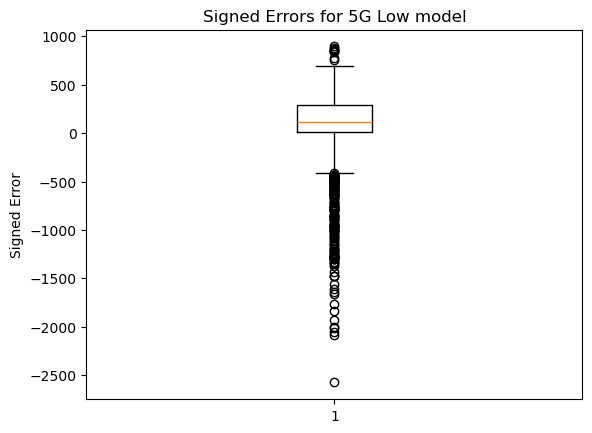

In [35]:
import matplotlib.pyplot as plt
plt.boxplot(flattened_errors)
plt.title('Signed Errors for 5G Low model')
plt.ylabel('Signed Error')